In [42]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# Paths to original images in Kaggle
original_image_train_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/train'
original_image_val_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/val'
original_image_test_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/test'# Image Data Generators for training, validation, and testing

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading images from directories
train_generator1 = train_datagen.flow_from_directory(
    original_image_train_path,
    target_size=(256, 256),  # VGG16 input size
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

val_generator1 = val_test_datagen.flow_from_directory(
    original_image_val_path,
    target_size=(256, 256),  # VGG16 input size
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator1 = val_test_datagen.flow_from_directory(
    original_image_test_path,
    target_size=(256, 256),  # VGG16 input size
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important: keep test data order for accurate evaluation
)

Found 13996 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3004 images belonging to 4 classes.


In [43]:
nidchdata = '/kaggle/input/nidch-data'
nidch_datagen = ImageDataGenerator(rescale=1./255)
# Loading images from directories
nidch_generator1 = nidch_datagen.flow_from_directory(
    nidchdata,
    target_size=(299, 299),  # VGG16 input size
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

Found 28 images belonging to 4 classes.


In [12]:
# Paths to original images in Kaggle
segmented_image_train_path = '/kaggle/input/dataset/Segmented Dataset (Split)/Segmentation Dataset (Split)/train'
segmented_image_val_path = '/kaggle/input/dataset/Segmented Dataset (Split)/Segmentation Dataset (Split)/val'
segmented_image_test_path = '/kaggle/input/dataset/Segmented Dataset (Split)/Segmentation Dataset (Split)/test'# Image Data Generators for training, validation, and testing

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading images from directories
train_generator2 = train_datagen.flow_from_directory(
    segmented_image_train_path,
    target_size=(256, 256),  
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

val_generator2 = val_test_datagen.flow_from_directory(
    segmented_image_val_path,
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator2 = val_test_datagen.flow_from_directory(
    segmented_image_test_path,
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important: keep test data order for accurate evaluation
)

Found 13996 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3004 images belonging to 4 classes.


In [14]:
# Custom data generator for ensemble model
def ensemble_data_generator(generator):
    for x, y in generator:
        yield [x, x], y  # Yield the same batch for both models

# Paths to original images
original_image_train_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/train'
original_image_val_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/val'
original_image_test_path = '/kaggle/input/dataset/Original Dataset (Split)/Original Dataset (Split)/test'

# Image Data Generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading images from directories
train_generator3 = train_datagen.flow_from_directory(
    original_image_train_path,
    target_size=(256, 256),  # Resize for EfficientNet-B2
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

val_generator3 = val_test_datagen.flow_from_directory(
    original_image_val_path,
    target_size=(256, 256),  # Resize for EfficientNet-B2
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator3 = val_test_datagen.flow_from_directory(
    original_image_test_path,
    target_size=(256, 256),  # Resize for EfficientNet-B2
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important: keep test data order for accurate evaluation
)

Found 13996 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3004 images belonging to 4 classes.


In [ ]:
output_signature = (
    (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Input for EfficientNet-B2
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32)   # Input for ResNet-50
    ),
    tf.TensorSpec(shape=(None, 4), dtype=tf.float32)  # Labels (one-hot encoded)
)

# Create TensorFlow datasets from the custom generator
train_ensemble_dataset = tf.data.Dataset.from_generator(
    lambda: ensemble_data_generator(train_generator3),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

val_ensemble_dataset = tf.data.Dataset.from_generator(
    lambda: ensemble_data_generator(val_generator3),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

test_ensemble_dataset = tf.data.Dataset.from_generator(
    lambda: ensemble_data_generator(test_generator3),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

# **InceptionV3 - Model1**

In [4]:
# Load the InceptionV3 model with pre-trained ImageNet weights
base_model1 = InceptionV3(weights='/kaggle/input/inceptionv3/tensorflow2/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model's layers
for layer in base_model1.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model1.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model1 = Model(inputs=base_model1.input, outputs=predictions)

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
print(len(model1.layers))

315


In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/INCEPTIONV3_model_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/INCEPTIONV3_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model1.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/INCEPTIONV3_trained_model_original_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/INCEPTIONV3_original_image_test_classification_report.csv', index=True)

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/INCEPTIONV3_model_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/INCEPTIONV3_trained_model_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model1.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/INCEPTIONV3_trained_model_segmented_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/INCEPTIONV3_segmented_image_test_classification_report.csv', index=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/working/INCEPTIONV3_model_original_images_training_results.csv"
csv2 = "/kaggle/working/INCEPTIONV3_model_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('InceptionV3', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Dataset', color='blue', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Dataset', color='blue', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Dataset', color='red', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Dataset', color='blue', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Dataset', color='blue', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Dataset', color='red', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/InceptionV3-Comparison.png')

# Show the plots
plt.show()

In [ ]:
# SE Block function
def se_block(input_tensor, reduction_ratio=16):
    """
    Squeeze-and-Excitation Block
    Args:
        input_tensor (tf.Tensor): input feature map tensor.
        reduction_ratio (int): reduction ratio for bottleneck layers.
    Returns:
        tf.Tensor: feature map tensor with channel-wise attention.
    """
    filters = input_tensor.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)
    
    # Squeeze operation: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    # Excitation operation: two dense layers
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    
    # Scale operation: scale the input by the SE weights
    x = Multiply()([input_tensor, se])
    return x

# Load the InceptionV3 base model
base_model01 = InceptionV3(weights='/kaggle/input/inceptionv3/tensorflow2/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                         include_top=False, input_shape=(299, 299, 3))

# Apply SE blocks after certain layers in InceptionV3
x = base_model01.output
x = se_block(x)  # Adding SE block after the base model's final layer output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Build and compile the model
model01 = Model(inputs=base_model01.input, outputs=predictions)
model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model01.summary()

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/INCEPTIONV3_model_with_SE_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/INCEPTIONV3_trained_model_with_SE_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [ ]:
# Train the model
history = model01.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=10,
    callbacks=callbacks
)

In [45]:
# Evaluate on test data
saved_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(nidch_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(nidch_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(nidch_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(nidch_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/INCEPTIONV3_with_SE_test_classification_report.csv', index=True)
print(df_report)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.4762 - loss: 1.6147
Test Loss: 1.6249, Test Accuracy: 0.4643
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
Confusion Matrix
[[2 0 0 0]
 [4 5 1 8]
 [1 0 0 1]
 [1 1 0 4]]
Classification Report
              precision    recall  f1-score    support
NORMAL         0.250000  1.000000  0.400000   2.000000
COVID          0.833333  0.277778  0.416667  18.000000
PNEUMONIA      0.000000  0.000000  0.000000   2.000000
TUBERCULOSIS   0.307692  0.666667  0.421053   6.000000
accuracy       0.392857  0.392857  0.392857   0.392857
macro avg      0.347756  0.486111  0.309430  28.000000
weighted avg   0.619505  0.392857  0.386654  28.000000


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4762 - loss: 1.4927
Test Loss: 1.6249, Test Accuracy: 0.4643
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


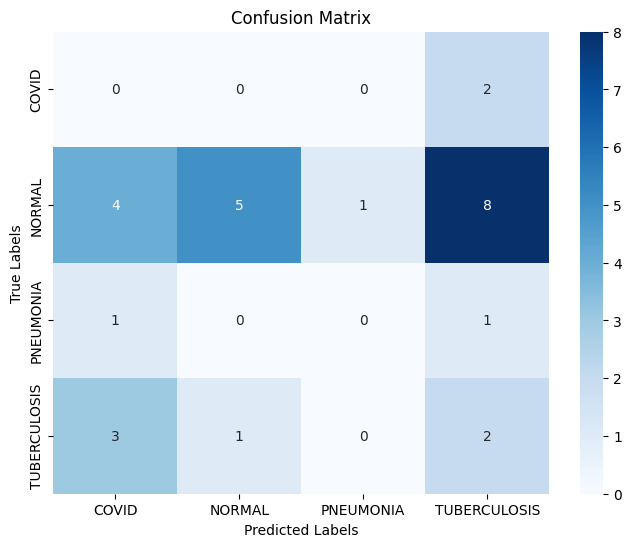

Confusion matrix saved as: /kaggle/working/VGG16_with_SE_original_image_confusion_matrix.png
              precision    recall  f1-score  support
COVID          0.000000  0.000000  0.000000     2.00
NORMAL         0.833333  0.277778  0.416667    18.00
PNEUMONIA      0.000000  0.000000  0.000000     2.00
TUBERCULOSIS   0.153846  0.333333  0.210526     6.00
accuracy       0.250000  0.250000  0.250000     0.25
macro avg      0.246795  0.152778  0.156798    28.00
weighted avg   0.568681  0.250000  0.312970    28.00


In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
saved_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(nidch_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(nidch_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Define class names
target_names = ['COVID', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

# Generate confusion matrix
cm = confusion_matrix(nidch_generator1.classes, y_pred)

# Plot confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the image
cm_image_path = '/kaggle/working/VGG16_with_SE_original_image_confusion_matrix.png'
plt.savefig(cm_image_path, dpi=300)
plt.show()

print(f"Confusion matrix saved as: {cm_image_path}")

# Generate and print classification report
report = classification_report(nidch_generator1.classes, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Save classification report as CSV
df_report.to_csv('/kaggle/working/VGG16_with_SE_original_image_test_classification_report.csv', index=True)
print(df_report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3155 - loss: 4.3976
Test Loss: 4.5944, Test Accuracy: 0.2857
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


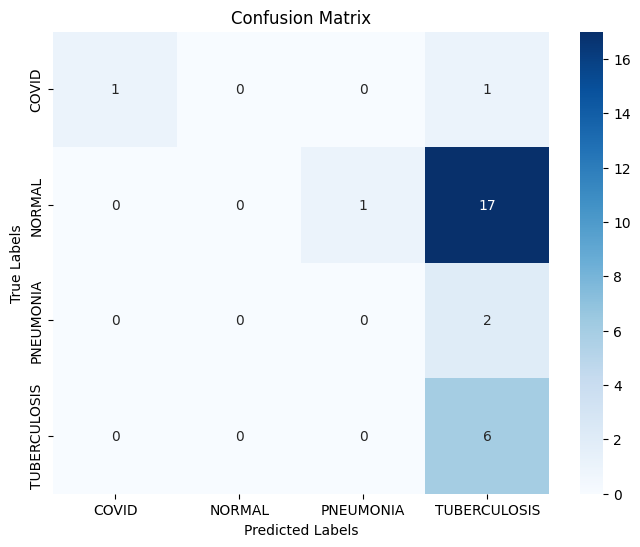

Confusion matrix saved as: /kaggle/working/classification_confusion_matrix.png
              precision  recall  f1-score  support
COVID          1.000000   0.500  0.666667     2.00
NORMAL         0.000000   0.000  0.000000    18.00
PNEUMONIA      0.000000   0.000  0.000000     2.00
TUBERCULOSIS   0.230769   1.000  0.375000     6.00
accuracy       0.250000   0.250  0.250000     0.25
macro avg      0.307692   0.375  0.260417    28.00
weighted avg   0.120879   0.250  0.127976    28.00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Define class labels
target_names = ["COVID", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]

# Load the trained classification model
classification_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_segmented_images.keras'
classification_model = load_model(classification_model_path)

# Function to get Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name="mixed10"):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads[..., np.newaxis])

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Evaluate model and get predictions
test_loss, test_accuracy = classification_model.evaluate(nidch_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions
Y_pred = classification_model.predict(nidch_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(nidch_generator1.classes, y_pred)

# Plot confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix image
cm_image_path = '/kaggle/working/classification_confusion_matrix.png'
plt.savefig(cm_image_path, dpi=300)
plt.show()

print(f"Confusion matrix saved as: {cm_image_path}")

# Print classification report
report = classification_report(nidch_generator1.classes, y_pred, target_names=target_names, output_dict=True)
print(pd.DataFrame(report).transpose())

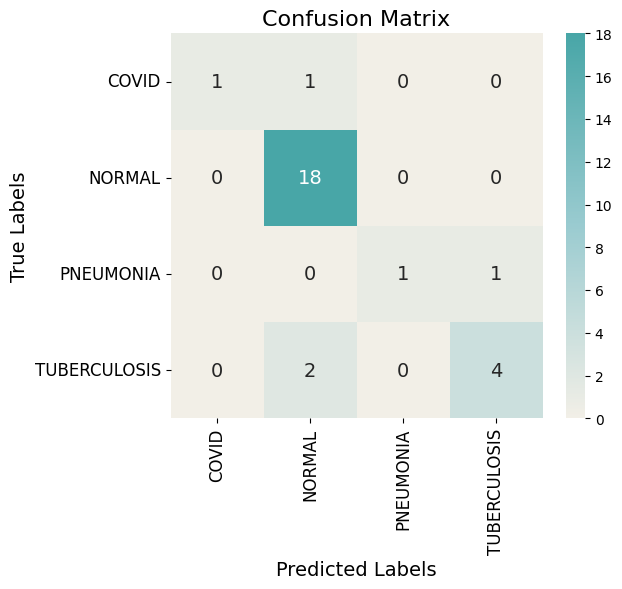

Confusion matrix saved as: auto_generated_confusion_matrix.png


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Define class labels
target_names = ["COVID", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]

# Manually define true labels and predicted labels
true_labels = (
    [1] * 18 +   # 18 NORMAL cases
    [0] * 2 +    # 2 COVID cases
    [2] * 2 +    # 2 PNEUMONIA cases
    [3] * 6      # 6 TUBERCULOSIS cases
)

predicted_labels = (
    [1] * 18 +  # All 18 NORMAL correctly predicted
    [0, 1] +    # 1 COVID correct, 1 misclassified as NORMAL
    [2, 3] +    # 1 PNEUMONIA correct, 1 misclassified as TUBERCULOSIS
    [3, 3, 3, 3, 1, 1]  # 4 TUBERCULOSIS correct, 2 misclassified as NORMAL
)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#F2EFE7", "#9ACBD0", "#48A6A7"])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap=custom_cmap, 
    xticklabels=target_names, yticklabels=target_names, 
    annot_kws={"size": 14}  # Adjust number text size
)

# Customize font sizes and text rotation
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)  # **Y-axis labels set to horizontal**

# Save the confusion matrix image
cm_image_path = 'auto_generated_confusion_matrix.png'
plt.savefig(cm_image_path, dpi=300)
plt.show()

print(f"Confusion matrix saved as: {cm_image_path}")

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/INCEPTIONV3_model_with_SE_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/INCEPTIONV3_trained_model_with_SE_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [ ]:
# Train the model
history = model01.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=10,
    callbacks=callbacks
)

In [4]:
# Evaluate on test data
saved_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['COVID', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/INCEPTIONV3_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731339139.478030     153 service.cc:145] XLA service 0x7b2fc4003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731339139.478083     153 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/188 ━━━━━━━━━━━━━━━━━━━━ 33:37 11s/step - accuracy: 0.8750 - loss: 0.1594

I0000 00:00:1731339146.277373     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9323 - loss: 0.2308
Test Loss: 0.1748, Test Accuracy: 0.9491
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step
Confusion Matrix
[[695  12  17  27]
 [  8 708  27   8]
 [  2  32 713   4]
 [  5   9   2 735]]
Classification Report
              precision    recall  f1-score      support
COVID          0.978873  0.925433  0.951403   751.000000
NORMAL         0.930355  0.942743  0.936508   751.000000
PNEUMONIA      0.939394  0.949401  0.944371   751.000000
TUBERCULOSIS   0.949612  0.978695  0.963934   751.000000
accuracy       0.949068  0.949068  0.949068     0.949068
macro avg      0.949559  0.949068  0.949054  3004.000000
weighted avg   0.949559  0.949068  0.949054  3004.000000


In [ ]:
# Evaluate on test data
saved_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['COVID', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/INCEPTIONV3_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

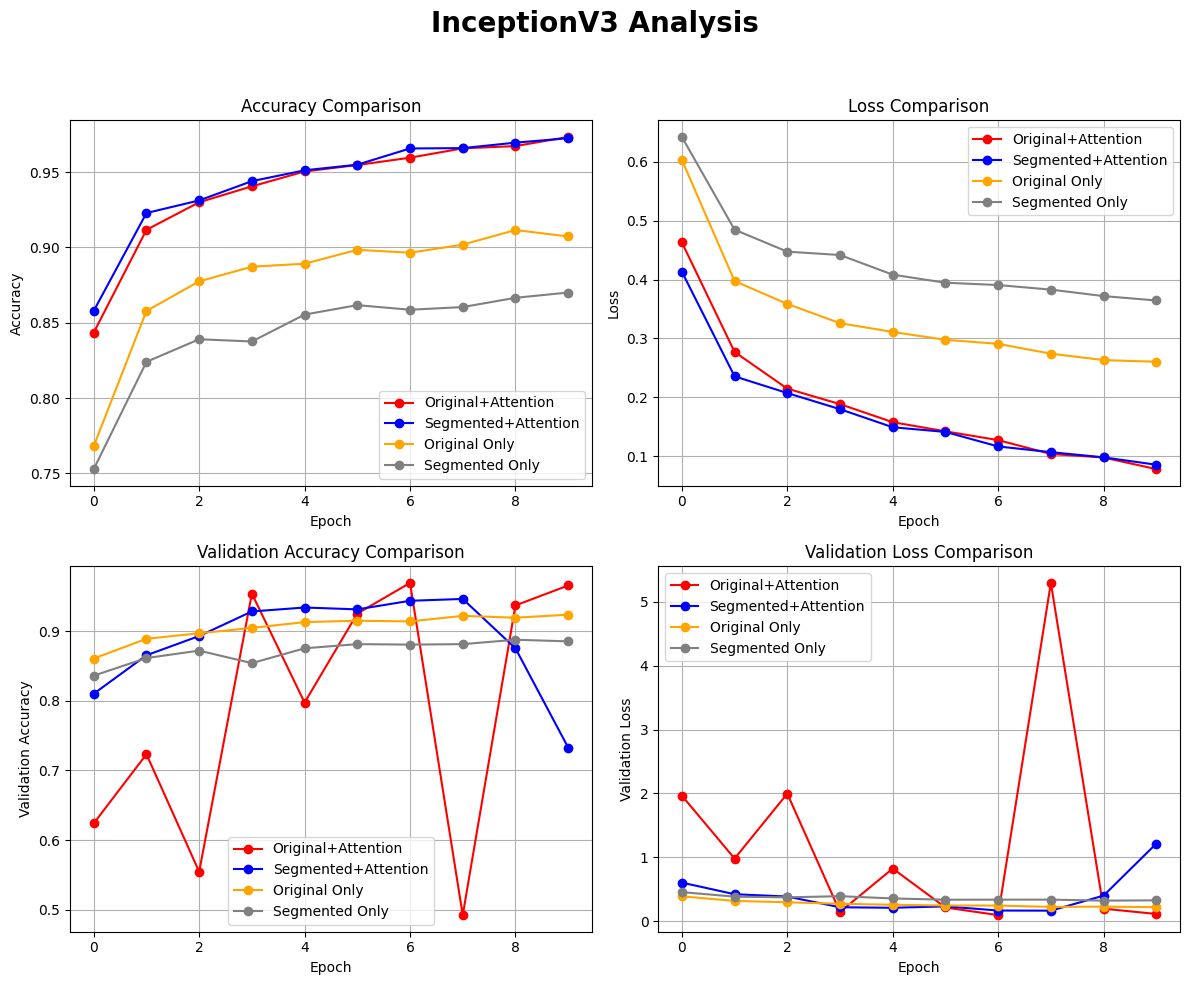

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/input/training-results/INCEPTIONV3_model_original_images_training_results.csv"
csv2 = "/kaggle/input/training-results/INCEPTIONV3_model_segmented_images_training_results.csv"
csv3 = "/kaggle/input/training-results/INCEPTIONV3_model_with_SE_original_images_training_results.csv"
csv4 = "/kaggle/input/training-results/INCEPTIONV3_model_with_SE_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original_attention = pd.read_csv(csv3)
df_segmented_attention = pd.read_csv(csv4)
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('InceptionV3 Analysis', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original_attention['epoch'], df_original_attention['accuracy'], label='Original+Attention', color='red', marker='o')
axs[0, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Only', color='orange', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Only', color='grey', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original_attention['epoch'], df_original_attention['loss'], label='Original+Attention', color='red', marker='o')
axs[0, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['loss'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Only', color='orange', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Only', color='grey', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original_attention['epoch'], df_original_attention['val_accuracy'], label='Original+Attention', color='red', marker='o')
axs[1, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['val_accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Only', color='orange', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Only', color='grey', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original_attention['epoch'], df_original_attention['val_loss'], label='Original+Attention', color='red', marker='o')
axs[1, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['val_loss'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Only', color='orange', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Only', color='grey', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/InceptionV3_Combined_Comparison.png')

# Show the plots
plt.show()

# **VGG16 - Model2**

In [3]:
# Load the model from the .h5 file
base_model2 = VGG16(weights='/kaggle/input/vgg-16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers to prevent them from being trained
for layer in base_model2.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model2.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = tf.keras.layers.Dropout(0.5)(x)   # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model2 = Model(inputs=base_model2.input, outputs=predictions)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
print(len(model2.layers))

23


In [ ]:
# Check the shape of the images in the training generator
batch_train_images, _ = next(train_generator2)
print(f"Train Generator - Image batch shape: {batch_train_images.shape}")

# Check the shape of the images in the validation generator
batch_val_images, _ = next(val_generator2)
print(f"Validation Generator - Image batch shape: {batch_val_images.shape}")

# Check the shape of the images in the test generator
batch_test_images, _ = next(test_generator2)
print(f"Test Generator - Image batch shape: {batch_test_images.shape}")

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/VGG16_model_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/VGG16_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model2.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/VGG16_trained_model_original_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/VGG16_original_image_test_classification_report.csv', index=True)

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/VGG16_model_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/VGG16_trained_model_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model2.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/VGG16_trained_model_segmented_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/VGG16_segmented_image_test_classification_report.csv', index=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/working/VGG16_model_original_images_training_results.csv"
csv2 = "/kaggle/working/VGG16_model_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('VGG16', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Dataset', color='blue', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Dataset', color='blue', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Dataset', color='red', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Dataset', color='blue', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Dataset', color='blue', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Dataset', color='red', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/VGG16-Comparison.png')

# Show the plots
plt.show()

In [ ]:
# SE Block function
def se_block(input_tensor, reduction_ratio=16):
    """
    Squeeze-and-Excitation Block
    Args:
        input_tensor (tf.Tensor): input feature map tensor.
        reduction_ratio (int): reduction ratio for bottleneck layers.
    Returns:
        tf.Tensor: feature map tensor with channel-wise attention.
    """
    filters = input_tensor.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)
    
    # Squeeze operation: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    # Excitation operation: two dense layers
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    
    # Scale operation: scale the input by the SE weights
    x = Multiply()([input_tensor, se])
    return x

# Load the VGG16 base model
base_model02 = VGG16(
    weights='/kaggle/input/vgg-16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Freeze the base model's layers to prevent them from being trained
for layer in base_model02.layers:
    layer.trainable = False

# Add SE block and classification layers on top of the base model
x = base_model02.output
x = se_block(x)  # Add SE block after the base model's output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model02 = Model(inputs=base_model02.input, outputs=predictions)

# Compile the model
model02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model02.summary()

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/VGG16_model_with_SE_original_images_training_results1.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/VGG16_trained_model_with_SE_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc]

In [ ]:
history = model02.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=10,
    callbacks=callbacks
)

In [44]:
# Evaluate on test data
saved_model_path = '/kaggle/working/VGG16_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(nidch_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(nidch_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(nidch_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(nidch_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/VGG16_with_SE_original_image_test_classification_report.csv', index=True)
print(df_report)

ValueError: File not found: filepath=/kaggle/working/VGG16_trained_model_with_SE_original_images.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/VGG16_model_with_SE_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/VGG16_trained_model_with_SE_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [ ]:
# Train the model
history = model02.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=10,
    callbacks=callbacks
)

In [ ]:
# Evaluate on test data
saved_model_path = '/kaggle/working/VGG16_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/VGG16_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/input/training-results/VGG16_model_original_images_training_results.csv"
csv2 = "/kaggle/input/training-results/VGG16_model_segmented_images_training_results.csv"
csv3 = "/kaggle/working/VGG16_model_with_SE_original_images_training_results1.csv"
csv4 = "/kaggle/working/VGG16_model_with_SE_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original_attention = pd.read_csv(csv3)
df_segmented_attention = pd.read_csv(csv4)
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('VGG16 Analysis', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original_attention['epoch'], df_original_attention['accuracy'], label='Original+Attention', color='red', marker='o')
axs[0, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Only', color='orange', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Only', color='grey', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original_attention['epoch'], df_original_attention['loss'], label='Original+Attention', color='red', marker='o')
axs[0, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['loss'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Only', color='orange', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Only', color='grey', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original_attention['epoch'], df_original_attention['val_accuracy'], label='Original+Attention', color='red', marker='o')
axs[1, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['val_accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Only', color='orange', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Only', color='grey', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original_attention['epoch'], df_original_attention['val_loss'], label='Original+Attention', color='red', marker='o')
axs[1, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['val_loss'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Only', color='orange', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Only', color='grey', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/VGG16_Combined_Comparison.png')

# Show the plots
plt.show()

# **ResNet-50 - Model3**

In [5]:
# Load the ResNet-50 model with pre-trained ImageNet weights
base_model3 = ResNet50(weights='/kaggle/input/resnet-50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model3.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model3.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model3 = Model(inputs=base_model3.input, outputs=predictions)

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
print(len(model3.layers))

179


In [ ]:
# Check the shape of the images in the training generator
batch_train_images, _ = next(train_generator2)
print(f"Train Generator - Image batch shape: {batch_train_images.shape}")

# Check the shape of the images in the validation generator
batch_val_images, _ = next(val_generator2)
print(f"Validation Generator - Image batch shape: {batch_val_images.shape}")

# Check the shape of the images in the test generator
batch_test_images, _ = next(test_generator2)
print(f"Test Generator - Image batch shape: {batch_test_images.shape}")

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/RESNET-50_model_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/RESNET-50_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model3.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/RESNET-50_trained_model_original_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/RESNET-50_original_image_test_classification_report.csv', index=True)

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/RESNET-50_model_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/RESNET-50_trained_model_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model3.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/RESNET-50_trained_model_segmented_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/RESNET-50_segmented_image_test_classification_report.csv', index=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/working/RESNET-50_model_original_images_training_results.csv"
csv2 = "/kaggle/working/RESNET-50_model_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('ResNet-50', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Dataset', color='blue', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Dataset', color='blue', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Dataset', color='red', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Dataset', color='blue', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Dataset', color='blue', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Dataset', color='red', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/ResNet-50-Comparison.png')

# Show the plots
plt.show()

In [ ]:
# SE Block function
def se_block(input_tensor, reduction_ratio=16):
    """
    Squeeze-and-Excitation Block
    Args:
        input_tensor (tf.Tensor): input feature map tensor.
        reduction_ratio (int): reduction ratio for bottleneck layers.
    Returns:
        tf.Tensor: feature map tensor with channel-wise attention.
    """
    filters = input_tensor.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)
    
    # Squeeze operation: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    # Excitation operation: two dense layers
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    
    # Scale operation: scale the input by the SE weights
    x = Multiply()([input_tensor, se])
    return x

# Load the ResNet-50 base model
base_model03 = ResNet50(
    weights='/kaggle/input/resnet-50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Freeze the base model's layers
for layer in base_model03.layers:
    layer.trainable = False

# Add SE block and classification layers on top of the base model
x = base_model03.output
x = se_block(x)  # Add SE block after the base model's output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model03 = Model(inputs=base_model03.input, outputs=predictions)

# Compile the model
model03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model03.summary()

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/RESNET-50_model_with_SE_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/RESNET-50_trained_model_with_SE_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [ ]:
# Train the model
history = model03.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=10,
    callbacks=callbacks
)

In [ ]:
# Evaluate on test data
saved_model_path = '/kaggle/working/RESNET-50_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/RESNET-50_with_SE_original_image_test_classification_report.csv', index=True)
print(df_report)

In [ ]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/RESNET-50_model_with_SE_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/RESNET-50_trained_model_with_SE_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [ ]:
# Train the model
history = model03.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=10,
    callbacks=callbacks
)

In [ ]:
# Evaluate on test data
saved_model_path = '/kaggle/working/RESNET-50_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/RESNET-50_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/input/training-results/RESNET-50_model_original_images_training_results.csv"
csv2 = "/kaggle/input/training-results/RESNET-50_model_segmented_images_training_results.csv"
csv3 = "/kaggle/working/RESNET-50_model_with_SE_original_images_training_results1.csv"
csv4 = "/kaggle/working/RESNET-50_model_with_SE_segmented_images_training_results1.csv"

# Load the CSV files into DataFrames
df_original_attention = pd.read_csv(csv3)
df_segmented_attention = pd.read_csv(csv4)
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('RESNET-50 Analysis', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original_attention['epoch'], df_original_attention['accuracy'], label='Original+Attention', color='red', marker='o')
axs[0, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Only', color='orange', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Only', color='grey', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original_attention['epoch'], df_original_attention['loss'], label='Original+Attention', color='red', marker='o')
axs[0, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['loss'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Only', color='orange', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Only', color='grey', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original_attention['epoch'], df_original_attention['val_accuracy'], label='Original+Attention', color='red', marker='o')
axs[1, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['val_accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Only', color='orange', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Only', color='grey', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original_attention['epoch'], df_original_attention['val_loss'], label='Original+Attention', color='red', marker='o')
axs[1, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['val_loss'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Only', color='orange', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Only', color='grey', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/RESNET-50_Combined_Comparison.png')

# Show the plots
plt.show()

# **DenseNet-121 - Model4**

In [12]:
# Load the DenseNet-121 model with pre-trained ImageNet weights
model44 = DenseNet121(weights='/kaggle/input/densenet-121/tensorflow2/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Show model summary
model44.summary()
print(len(model44.layers))

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

427


In [6]:
# Load the DenseNet-121 model with pre-trained ImageNet weights
base_model4 = DenseNet121(weights='/kaggle/input/densenet-121/tensorflow2/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model4.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model4.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model4 = Model(inputs=base_model4.input, outputs=predictions)

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
print(len(model4.layers))

431


In [ ]:
# Check the shape of the images in the training generator
batch_train_images, _ = next(train_generator2)
print(f"Train Generator - Image batch shape: {batch_train_images.shape}")

# Check the shape of the images in the validation generator
batch_val_images, _ = next(val_generator2)
print(f"Validation Generator - Image batch shape: {batch_val_images.shape}")

# Check the shape of the images in the test generator
batch_test_images, _ = next(test_generator2)
print(f"Test Generator - Image batch shape: {batch_test_images.shape}")

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/DENSENET-121_model_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/DENSENET-121_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model4.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/DENSENET-121_trained_model_original_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/DENSENET-121_original_image_test_classification_report.csv', index=True)

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/DENSENET-121_model_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/DENSENET-121_trained_model_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model4.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/DENSENET-121_trained_model_segmented_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/DENSENET-121_segmented_image_test_classification_report.csv', index=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/working/DENSENET-121_model_original_images_training_results.csv"
csv2 = "/kaggle/working/DENSENET-121_model_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('DenseNet-121', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Dataset', color='blue', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Dataset', color='blue', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Dataset', color='red', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Dataset', color='blue', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Dataset', color='blue', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Dataset', color='red', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/DenseNet-121-Comparison.png')

# Show the plots
plt.show()

In [4]:
def se_block(input_tensor, reduction_ratio=16):
    """
    Squeeze-and-Excitation Block
    Args:
        input_tensor (tf.Tensor): input feature map tensor.
        reduction_ratio (int): reduction ratio for bottleneck layers.
    Returns:
        tf.Tensor: feature map tensor with channel-wise attention.
    """
    filters = input_tensor.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)
    
    # Squeeze operation: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    
    # Excitation operation: two dense layers
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    
    # Scale operation: scale the input by the SE weights
    x = Multiply()([input_tensor, se])
    return x

# Load the DenseNet-121 model with pre-trained ImageNet weights
base_model04 = DenseNet121(weights='/kaggle/input/densenet-121/tensorflow2/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                          include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model04.layers:
    layer.trainable = False

# Add SE block and new classification layers on top of the base model
x = base_model04.output
x = se_block(x)  # Add SE block after the base model's output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model04 = Model(inputs=base_model04.input, outputs=predictions)

# Compile the model
model04.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model04.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,433,092 (28.35 MB)

 Trainable params: 395,588 (1.51 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [5]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/DENSENET-121_model_with_SE_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/DENSENET-121_trained_model_with_SE_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [6]:
# Train the model
history = model04.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731357923.977929     140 service.cc:145] XLA service 0x7baa5c003ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731357923.977995     140 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/875 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.3542 - loss: 1.7417   

I0000 00:00:1731357937.554199     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7617 - loss: 0.6263
Epoch 1: val_accuracy improved from -inf to 0.90133, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 130s 118ms/step - accuracy: 0.7619 - loss: 0.6258 - val_accuracy: 0.9013 - val_loss: 0.2638
Epoch 2/10
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8991 - loss: 0.2903
Epoch 2: val_accuracy improved from 0.90133 to 0.92000, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8991 - loss: 0.2903 - val_accuracy: 0.9200 - val_loss: 0.2319
Epoch 3/10
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9239 - loss: 0.2267
Epoch 3: val_accuracy improved from 0.92000 to 0.92433, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9239 - loss: 0.2267 -

In [7]:
# Evaluate on test data
saved_model_path = '/kaggle/working/DENSENET-121_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/DENSENET-121_with_SE_original_image_test_classification_report.csv', index=True)
print(df_report)

188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9610 - loss: 0.1416
Test Loss: 0.1594, Test Accuracy: 0.9521
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step
Confusion Matrix
[[736   5   5   5]
 [ 21 697  24   9]
 [ 10  36 704   1]
 [ 26   1   1 723]]
Classification Report
              precision    recall  f1-score      support
NORMAL         0.928121  0.980027  0.953368   751.000000
COVID          0.943166  0.928096  0.935570   751.000000
PNEUMONIA      0.959128  0.937417  0.948148   751.000000
TUBERCULOSIS   0.979675  0.962716  0.971122   751.000000
accuracy       0.952064  0.952064  0.952064     0.952064
macro avg      0.952523  0.952064  0.952052  3004.000000
weighted avg   0.952523  0.952064  0.952052  3004.000000


In [8]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/DENSENET-121_model_with_SE_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/DENSENET-121_trained_model_with_SE_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [9]:
# Train the model
history = model04.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6066 - loss: 1.2439
Epoch 1: val_accuracy improved from -inf to 0.80600, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.6068 - loss: 1.2429 - val_accuracy: 0.8060 - val_loss: 0.5234
Epoch 2/10
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7947 - loss: 0.5772
Epoch 2: val_accuracy improved from 0.80600 to 0.85400, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.7947 - loss: 0.5771 - val_accuracy: 0.8540 - val_loss: 0.4091
Epoch 3/10
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8411 - loss: 0.4617
Epoch 3: val_accuracy improved from 0.85400 to 0.87600, saving model to /kaggle/working/DENSENET-121_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8411 - loss: 0.4617 

In [10]:
# Evaluate on test data
saved_model_path = '/kaggle/working/DENSENET-121_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/DENSENET-121_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.9159 - loss: 0.2797
Test Loss: 0.2772, Test Accuracy: 0.9118
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step
Confusion Matrix
[[700  19  11  21]
 [ 42 654  24  31]
 [  9  52 684   6]
 [ 31  17   2 701]]
Classification Report
              precision    recall  f1-score      support
NORMAL         0.895141  0.932091  0.913242   751.000000
COVID          0.881402  0.870839  0.876088   751.000000
PNEUMONIA      0.948682  0.910786  0.929348   751.000000
TUBERCULOSIS   0.923584  0.933422  0.928477   751.000000
accuracy       0.911784  0.911784  0.911784     0.911784
macro avg      0.912202  0.911784  0.911789  3004.000000
weighted avg   0.912202  0.911784  0.911789  3004.000000


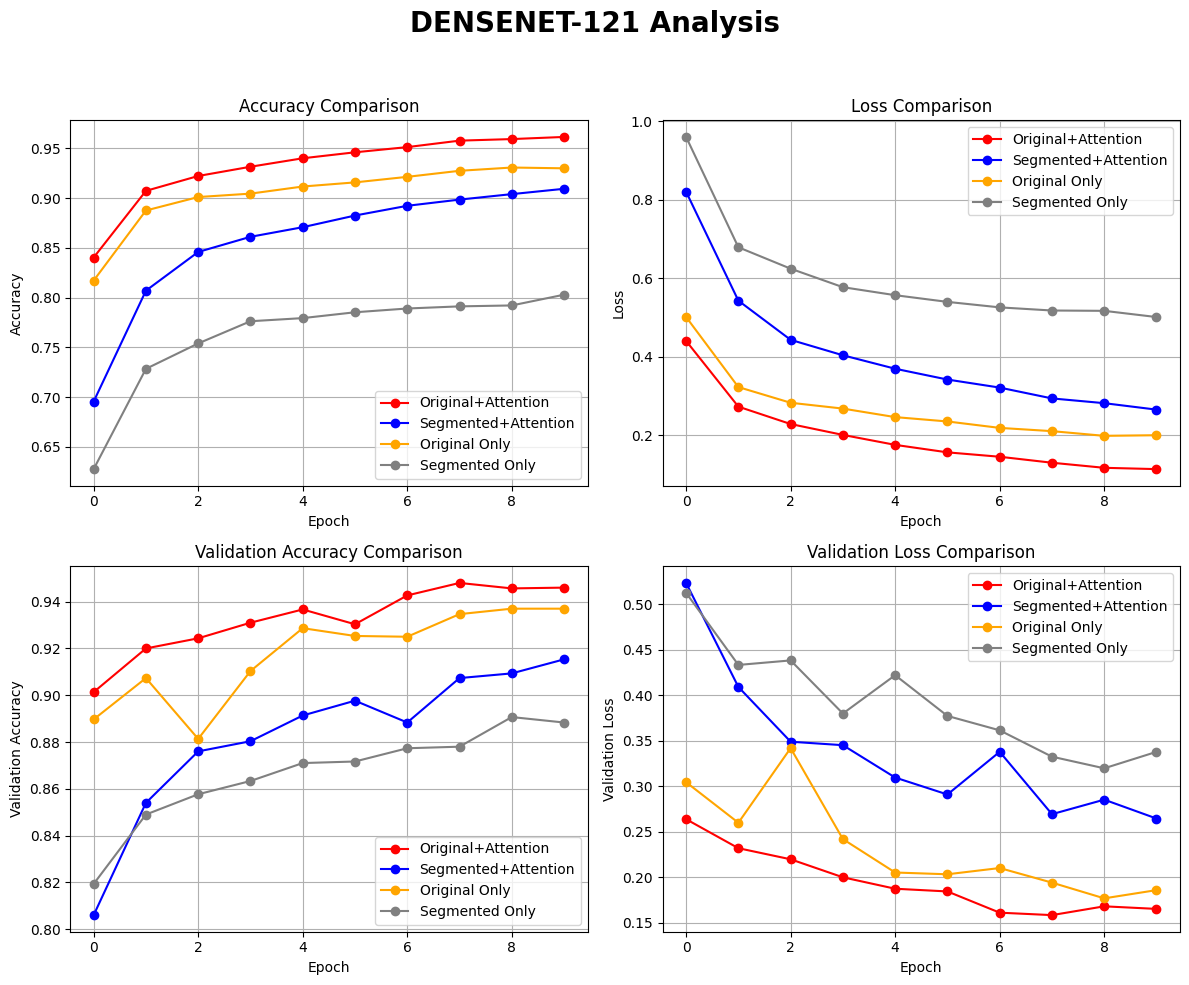

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/input/training-results/DENSENET-121_model_original_images_training_results.csv"
csv2 = "/kaggle/input/training-results/DENSENET-121_model_segmented_images_training_results.csv"
csv3 = "/kaggle/working/DENSENET-121_model_with_SE_original_images_training_results.csv"
csv4 = "/kaggle/working/DENSENET-121_model_with_SE_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original_attention = pd.read_csv(csv3)
df_segmented_attention = pd.read_csv(csv4)
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('DENSENET-121 Analysis', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original_attention['epoch'], df_original_attention['accuracy'], label='Original+Attention', color='red', marker='o')
axs[0, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Only', color='orange', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Only', color='grey', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original_attention['epoch'], df_original_attention['loss'], label='Original+Attention', color='red', marker='o')
axs[0, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['loss'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Only', color='orange', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Only', color='grey', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original_attention['epoch'], df_original_attention['val_accuracy'], label='Original+Attention', color='red', marker='o')
axs[1, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['val_accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Only', color='orange', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Only', color='grey', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original_attention['epoch'], df_original_attention['val_loss'], label='Original+Attention', color='red', marker='o')
axs[1, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['val_loss'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Only', color='orange', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Only', color='grey', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/DENSENET-121_Combined_Comparison.png')

# Show the plots
plt.show()

# **EfficientNetB2 - Model5**

In [ ]:
# Load the EfficientNetB2 model with pre-trained ImageNet weights
base_model5 = EfficientNetB2(weights='/kaggle/input/efficientnetb2/tensorflow2/default/1/efficientnetb2_notop.h5', include_top=False, input_shape=(260, 260, 3))
    
# Unfreeze the last 10 layers of EfficientNetB2 for fine-tuning
for layer in base_model5.layers[-10:]:
    layer.trainable = True

# Add new layers on top of the base model
x = base_model5.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model5 = Model(inputs=base_model5.input, outputs=predictions)

# Compile the model
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model5.summary()

In [ ]:
# Check the shape of the images in the training generator
batch_train_images, _ = next(train_generator1)
print(f"Train Generator - Image batch shape: {batch_train_images.shape}")

# Check the shape of the images in the validation generator
batch_val_images, _ = next(val_generator1)
print(f"Validation Generator - Image batch shape: {batch_val_images.shape}")

# Check the shape of the images in the test generator
batch_test_images, _ = next(test_generator1)
print(f"Test Generator - Image batch shape: {batch_test_images.shape}")

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/EFFICIENTNETB2_model_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/EFFICIENTNETB2_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model5.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/EFFICIENTNETB2_trained_model_original_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/EFFICIENTNETB2_original_image_test_classification_report.csv', index=True)

In [ ]:
# Callbacks for early stopping, model checkpoint, and CSV logger
csv_logger = CSVLogger('/kaggle/working/EFFICIENTNETB2_model_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/EFFICIENTNETB2_trained_model_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

# Combine callbacks
callbacks = [csv_logger, mc]

In [ ]:
# Set number of epochs
epochs = 10

# Train the model and save train/val metrics to CSV
history = model5.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
saved_model_path = '/kaggle/working/EFFICIENTNETB2_trained_model_segmented_images.keras'
model = load_model(saved_model_path)

# Evaluate the model on the test data and get classification metrics
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels for the test set
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix and classification report
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Convert classification report to dataframe and print metrics
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save classification report as CSV
df_report.to_csv('/kaggle/working/EFFICIENTNETB2_segmented_image_test_classification_report.csv', index=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/working/EFFICIENTNETB2_model_original_images_training_results.csv"
csv2 = "/kaggle/working/EFFICIENTNETB2_model_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('EfficientNetB2', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Dataset', color='blue', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Dataset', color='blue', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Dataset', color='red', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Dataset', color='blue', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Dataset', color='red', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Dataset', color='blue', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Dataset', color='red', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/EfficientNetB2-Comparison.png')

# Show the plots
plt.show()

In [22]:
# Define SE block function (same as before)
def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)

    # Squeeze operation: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)

    # Excitation operation: two dense layers
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    # Scale operation: scale the input by the SE weights
    x = Multiply()([input_tensor, se])
    return x

# Load the EfficientNetB2 model without the top layers
base_model05 = EfficientNetB2(weights='/kaggle/input/efficientnetb2/tensorflow2/default/1/efficientnetb2_notop.h5', 
                              include_top=False, input_shape=(260, 260, 3))

# Unfreeze the last 10 layers for fine-tuning
for layer in base_model05.layers[-10:]:
    layer.trainable = True

# Add SE block and classification layers on top of the base model
x = base_model05.output
x = se_block(x)  # Apply SE block
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer with 256 units
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(4, activation='softmax')(x)  # 4 output classes for classification

# Final model
model05 = models.Model(inputs=base_model05.input, outputs=predictions)

# Compile the model
model05.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model05.summary()

# Optionally clear session before starting training if running in a Jupyter notebook
from tensorflow.keras import backend as K
K.clear_session()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 260, 260,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 260, 260,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ normalization_2[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_

 Total params: 8,379,605 (31.97 MB)

 Trainable params: 8,312,030 (31.71 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [23]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/EFFICIENTNETB2_model_with_SE_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/EFFICIENTNETB2_trained_model_with_SE_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [24]:
# Train the model
history = model05.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6105 - loss: 1.0856
Epoch 1: val_accuracy improved from -inf to 0.87300, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 351s 247ms/step - accuracy: 0.6107 - loss: 1.0853 - val_accuracy: 0.8730 - val_loss: 0.4242
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9011 - loss: 0.3151
Epoch 2: val_accuracy improved from 0.87300 to 0.95400, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 124s 142ms/step - accuracy: 0.9011 - loss: 0.3151 - val_accuracy: 0.9540 - val_loss: 0.1512
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9313 - loss: 0.2169
Epoch 3: val_accuracy improved from 0.95400 to 0.96767, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_original_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 124s 141ms/step - accuracy: 0.9313 - l

In [25]:
# Evaluate on test data
saved_model_path = '/kaggle/working/EFFICIENTNETB2_trained_model_with_SE_original_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator1.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/EFFICIENTNETB2_with_SE_original_image_test_classification_report.csv', index=True)
print(df_report)

188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.1899 - loss: 64701.9375
Test Loss: 55212.7305, Test Accuracy: 0.2463
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step
Confusion Matrix
[[  0 479   0 272]
 [  0 538   0 213]
 [  0 663   0  88]
 [  3 546   0 202]]
Classification Report
              precision    recall  f1-score      support
NORMAL         0.000000  0.000000  0.000000   751.000000
COVID          0.241689  0.716378  0.361438   751.000000
PNEUMONIA      0.000000  0.000000  0.000000   751.000000
TUBERCULOSIS   0.260645  0.268975  0.264744   751.000000
accuracy       0.246338  0.246338  0.246338     0.246338
macro avg      0.125584  0.246338  0.156546  3004.000000
weighted avg   0.125584  0.246338  0.156546  3004.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/EFFICIENTNETB2_model_with_SE_segmented_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/EFFICIENTNETB2_trained_model_with_SE_segmented_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [27]:
# Train the model
history = model05.fit(
    train_generator2,
    validation_data=val_generator2,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8213 - loss: 0.5019
Epoch 1: val_accuracy improved from -inf to 0.93700, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 126s 143ms/step - accuracy: 0.8214 - loss: 0.5018 - val_accuracy: 0.9370 - val_loss: 0.1958
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9070 - loss: 0.2699
Epoch 2: val_accuracy improved from 0.93700 to 0.94567, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 123s 140ms/step - accuracy: 0.9070 - loss: 0.2699 - val_accuracy: 0.9457 - val_loss: 0.1681
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: 0.2211
Epoch 3: val_accuracy improved from 0.94567 to 0.95167, saving model to /kaggle/working/EFFICIENTNETB2_trained_model_with_SE_segmented_images.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 123s 140ms/step - accuracy: 0.9234 

In [28]:
# Evaluate on test data
saved_model_path = '/kaggle/working/EFFICIENTNETB2_trained_model_with_SE_segmented_images.keras'
model = tf.keras.models.load_model(saved_model_path)

test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions and classification report
Y_pred = model.predict(test_generator2)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

print('Classification Report')
target_names = ['NORMAL', 'COVID', 'PNEUMONIA', 'TUBERCULOSIS']
report = classification_report(test_generator2.classes, y_pred, target_names=target_names, output_dict=True)

# Save classification report
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/kaggle/working/EFFICIENTNETB2_with_SE_segmented_image_test_classification_report.csv', index=True)
print(df_report)

188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.0363 - loss: 22808968.0000
Test Loss: 21516542.0000, Test Accuracy: 0.2500
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step
Confusion Matrix
[[  0   0   0 751]
 [  0   0   0 751]
 [  0   0   0 751]
 [  0   0   0 751]]
Classification Report
              precision  recall  f1-score  support
NORMAL           0.0000    0.00      0.00   751.00
COVID            0.0000    0.00      0.00   751.00
PNEUMONIA        0.0000    0.00      0.00   751.00
TUBERCULOSIS     0.2500    1.00      0.40   751.00
accuracy         0.2500    0.25      0.25     0.25
macro avg        0.0625    0.25      0.10  3004.00
weighted avg     0.0625    0.25      0.10  3004.00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files (make sure to update these if needed)
csv1 = "/kaggle/input/training-results/DENSENET-121_model_original_images_training_results.csv"
csv2 = "/kaggle/input/training-results/DENSENET-121_model_segmented_images_training_results.csv"
csv3 = "/kaggle/working/DENSENET-121_model_with_SE_original_images_training_results.csv"
csv4 = "/kaggle/working/DENSENET-121_model_with_SE_segmented_images_training_results.csv"

# Load the CSV files into DataFrames
df_original_attention = pd.read_csv(csv3)
df_segmented_attention = pd.read_csv(csv4)
df_original = pd.read_csv(csv1)
df_segmented = pd.read_csv(csv2)

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Add a main title in the middle of the top of the figure
fig.suptitle('DENSENET-121 Analysis', fontsize=20, fontweight='bold', color='black')

# Plot Accuracy
axs[0, 0].plot(df_original_attention['epoch'], df_original_attention['accuracy'], label='Original+Attention', color='red', marker='o')
axs[0, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 0].plot(df_original['epoch'], df_original['accuracy'], label='Original Only', color='orange', marker='o')
axs[0, 0].plot(df_segmented['epoch'], df_segmented['accuracy'], label='Segmented Only', color='grey', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Loss
axs[0, 1].plot(df_original_attention['epoch'], df_original_attention['loss'], label='Original+Attention', color='red', marker='o')
axs[0, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['loss'], label='Segmented+Attention', color='blue', marker='o')
axs[0, 1].plot(df_original['epoch'], df_original['loss'], label='Original Only', color='orange', marker='o')
axs[0, 1].plot(df_segmented['epoch'], df_segmented['loss'], label='Segmented Only', color='grey', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Validation Accuracy
axs[1, 0].plot(df_original_attention['epoch'], df_original_attention['val_accuracy'], label='Original+Attention', color='red', marker='o')
axs[1, 0].plot(df_segmented_attention['epoch'], df_segmented_attention['val_accuracy'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 0].plot(df_original['epoch'], df_original['val_accuracy'], label='Original Only', color='orange', marker='o')
axs[1, 0].plot(df_segmented['epoch'], df_segmented['val_accuracy'], label='Segmented Only', color='grey', marker='o')
axs[1, 0].set_title('Validation Accuracy Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Validation Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Loss
axs[1, 1].plot(df_original_attention['epoch'], df_original_attention['val_loss'], label='Original+Attention', color='red', marker='o')
axs[1, 1].plot(df_segmented_attention['epoch'], df_segmented_attention['val_loss'], label='Segmented+Attention', color='blue', marker='o')
axs[1, 1].plot(df_original['epoch'], df_original['val_loss'], label='Original Only', color='orange', marker='o')
axs[1, 1].plot(df_segmented['epoch'], df_segmented['val_loss'], label='Segmented Only', color='grey', marker='o')
axs[1, 1].set_title('Validation Loss Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# Save the figure as a .png file
plt.savefig('/kaggle/working/DENSENET-121_Combined_Comparison.png')

# Show the plots
plt.show()

In [19]:
import os

# Path to the specific file you want to delete
file_path = '/kaggle/working/EFFICIENTNETB2-121_model_with_SE_original_images_training_results.csv'

# Check if the file exists
if os.path.exists(file_path):
    os.remove(file_path)  # Delete the file
    print(f"File {file_path} has been deleted.")
else:
    print(f"File {file_path} not found.")

File /kaggle/working/EFFICIENTNETB2-121_model_with_SE_original_images_training_results.csv has been deleted.


# **Testing Images**

/tmp/ipykernel_30/3593675055.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load(segmentation_model_path, map_location=torch.d

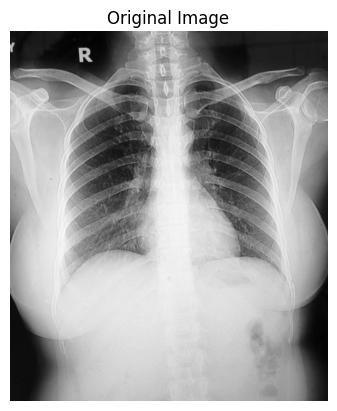

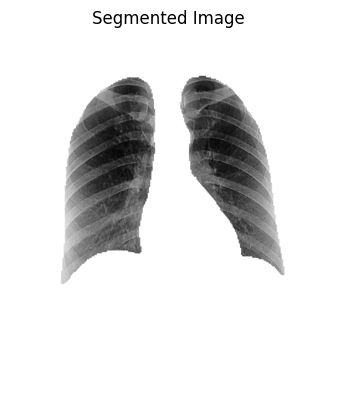

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: COVID, Probability: 0.55


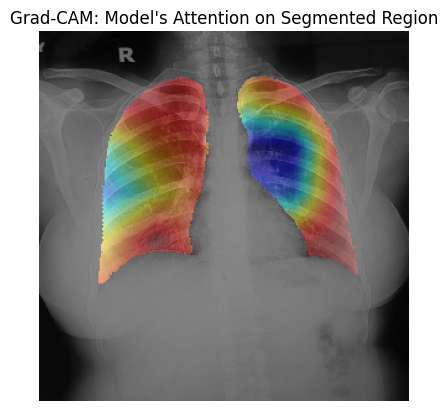

In [41]:
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Add the directory containing unet.py, unet_utils.py, and __init__.py to the Python path
sys.path.append('/kaggle/input/pretrained-unet/tensorflow2/default/1')

# Import the UNet model
from unet import UNet  # Adjust if the module path differs

# Define paths
segmentation_model_path = '/kaggle/input/unet/tensorflow2/default/1/UNET_trained_model_manually_annotated_mask_segmentation.pth'
classification_model_path = '/kaggle/input/trained-inceptionv3/tensorflow2/default/1/INCEPTIONV3_trained_model_with_SE_segmented_images.keras'

# Load the UNet model architecture and weights
segmentation_model = UNet(n_channels=1, n_classes=1)  # Adjust channels and classes if needed
segmentation_model.load_state_dict(torch.load(segmentation_model_path, map_location=torch.device('cpu')))
segmentation_model.eval()  # Set model to evaluation mode

# Load the classification model
classification_model = load_model(classification_model_path)

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name="mixed10"):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads[..., np.newaxis])

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Function to overlay Grad-CAM heatmap on the image
def display_gradcam_with_mask(img_path, heatmap, mask, alpha=0.4):
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (299, 299))

    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Masking heatmap
    mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.bitwise_and(heatmap, heatmap, mask=mask.astype(np.uint8))
    
    superimposed_img = heatmap * alpha + np.stack([original_image] * 3, axis=-1) * (1 - alpha)
    plt.imshow(superimposed_img.astype("uint8"))
    plt.title("Grad-CAM: Model's Attention on Segmented Region")
    plt.axis("off")
    plt.show()

# Function to preprocess, segment, classify, and visualize with Grad-CAM
def segment_and_classify_image(image_path):
    # Step 1: Load and display the original image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    # Step 2: Preprocess the image for the segmentation model
    input_image = cv2.resize(original_image, (256, 256))  # Resize as per UNet input
    input_tensor = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0  # Normalize and add batch and channel dimensions
    
    # Step 3: Generate the mask using UNet
    with torch.no_grad():
        predicted_mask = segmentation_model(input_tensor)
        predicted_mask = (predicted_mask.squeeze().numpy() > 0.5).astype(np.uint8)  # Threshold to binary mask
    
    # Step 4: Apply the mask to the original image to get the segmented lungs
    binary_mask = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))
    segmented_image = np.where(binary_mask, original_image, 255)  # Apply mask
    
    # Display the segmented image
    plt.imshow(segmented_image, cmap='gray')
    plt.title("Segmented Image")
    plt.axis("off")
    plt.show()

    # Step 5: Preprocess segmented image for classification
    segmented_image_resized = cv2.resize(segmented_image, (299, 299))  # Resize to match InceptionV3 input
    binary_mask = cv2.resize(predicted_mask, (299, 299))  # Match Grad-CAM dimensions
    segmented_image_expanded = np.expand_dims(segmented_image_resized, axis=-1)  # Add channel dimension
    segmented_image_expanded = np.repeat(segmented_image_expanded, 3, axis=-1)  # Repeat channels to simulate RGB
    input_data = np.expand_dims(segmented_image_expanded, axis=0) / 255.0  # Normalize and add batch dimension

    # Step 6: Classify using InceptionV3 model
    prediction = classification_model.predict(input_data)
    predicted_class = np.argmax(prediction)
    predicted_probability = prediction[0, predicted_class]  # Get probability of the predicted class
    class_labels = ["COVID", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]
    print(f"Predicted Class: {class_labels[predicted_class]}, Probability: {predicted_probability:.2f}")

    # Step 7: Generate and display Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(classification_model, input_data, predicted_class)
    display_gradcam_with_mask(uploaded_image_path, heatmap, binary_mask)

# Example usage
uploaded_image_path = '/kaggle/input/real-time-data-for-testing/NORMAL/NORMAL_9.jpeg'
segment_and_classify_image(uploaded_image_path)

# **Ensemble Model 01: EfficientNet-B2 and ResNet-50**

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [7]:
# Load EfficientNet-B2 and ResNet-50 models
effnet = EfficientNetB2(weights='/kaggle/input/efficientnetb2/tensorflow2/default/1/efficientnetb2_notop.h5', include_top=False, input_shape=(256, 256, 3))
resnet = ResNet50(weights='/kaggle/input/resnet-50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(256, 256, 3))

In [ ]:
# Freeze the base models
for layer in effnet.layers:
    layer.trainable = False
for layer in resnet.layers:
    layer.trainable = False

In [8]:
# Feature extraction from both models
effnet_output = effnet.output
effnet_output = GlobalAveragePooling2D()(effnet_output)

resnet_output = resnet.output
resnet_output = GlobalAveragePooling2D()(resnet_output)

# Concatenate features
combined = Concatenate()([effnet_output, resnet_output])

# Add dense layers
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 output classes

# Build the ensemble model
ensemble_model = Model(inputs=[effnet.input, resnet.input], outputs=predictions)

# Compile the model
ensemble_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
ensemble_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 32,242,301 (122.99 MB)

 Trainable params: 32,121,606 (122.53 MB)

 Non-trainable params: 120,695 (471.47 KB)

In [9]:
# Callbacks
csv_logger = CSVLogger('/kaggle/working/Ensemble_EffNetB2_ResNet50_original_images_training_results.csv', append=True)
mc = ModelCheckpoint(filepath='/kaggle/working/Ensemble_EffNetB2_ResNet50_trained_model_original_images.keras',
                     monitor='val_accuracy', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, min_delta=0.01)

callbacks = [csv_logger, mc, es]

In [15]:
# Create custom generators for training and validation
train_ensemble_generator = ensemble_data_generator(train_generator1)
val_ensemble_generator = ensemble_data_generator(val_generator1)

In [16]:
# Train the model
history = ensemble_model.fit(
    train_ensemble_generator,
    steps_per_epoch=len(train_generator1),
    validation_data=val_ensemble_generator,
    validation_steps=len(val_generator1),
    epochs=10,
    callbacks=callbacks
)

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.